#**DS340 Final Project: Emotion Classification**
### Daniel Skahill and Matthew Batacan

For our final project, we decided to tackle the problem of Emotion classification with the use of Neural Networks.



#### **Importing Dependencies**

We have decided to build our neural netwrok models using Keras.

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout,Conv2D,Input,RandomRotation,RandomFlip,RandomZoom
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np 
import os
import cv2
from PIL import Image
import seaborn as sns
import plotly.express as px
import pandas as pd
import copy
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
from google.colab import files
from random import seed
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
NUM_CLASSES = 5

## Loading the train and validation data 


### Kaggle dataset for model 1 

https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

In [ ]:
#Kaggle API key upload
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matthewbatacan","key":"6717eaba5c16c6853367546f5fc17511"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           5170        161  1.0              
mvieira101/global-cost-of-living                                Global Cost of Living                                 1MB  2022-12-03 16:37:53            843         36  0.9705882        
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25          21632        577  1.0              

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer
!unzip ./emotion-detection-fer.zip
!rm -r ./test/disgusted
!rm -r ./test/surprised
!rm -r ./train/disgusted
!rm -r ./train/surprised

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
kaggle_train_dir = '/content/train'
kaggle_test_dir = '/content/test'

In [ ]:
seed(340)
image_size = (48,48)
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   samplewise_std_normalization = True
                                  )

train_ds_kaggle = train_datagen.flow_from_directory(directory = kaggle_train_dir,
                                                    target_size = (image_size),
                                                    batch_size = 32,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2, samplewise_std_normalization = True)

val_ds_kaggle = validation_datagen.flow_from_directory( directory = kaggle_train_dir,
                                                              target_size = (image_size),
                                                              batch_size = 32,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1304: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 20082 images belonging to 5 classes.
Found 5020 images belonging to 5 classes.


### FER2013 data set (from Kaggle) for model 1 part 2
https://www.kaggle.com/datasets/deadskull7/fer2013/code

In [ ]:
!kaggle datasets download -d deadskull7/fer2013
!unzip ./fer2013.zip

 97% 94.0M/96.6M [00:03<00:00, 34.8MB/s]
100% 96.6M/96.6M [00:03<00:00, 26.4MB/s]
Archive:  ./fer2013.zip
  inflating: fer2013.csv             


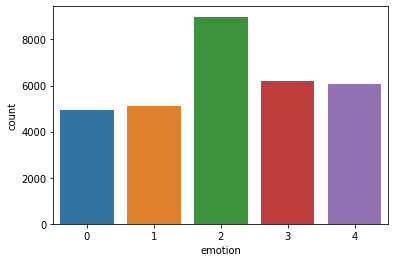

In [ ]:
data = pd.read_csv('/content/fer2013.csv')
# Change so numbers are consistent with other data sets identifications
data = data.loc[(data['emotion'] != 1)]
data = data.loc[(data['emotion']!= 5)]
data['emotion'] = data['emotion'].replace({2:1,3:2,6:3})
emotion_counts = sns.countplot(x='emotion', data=data)

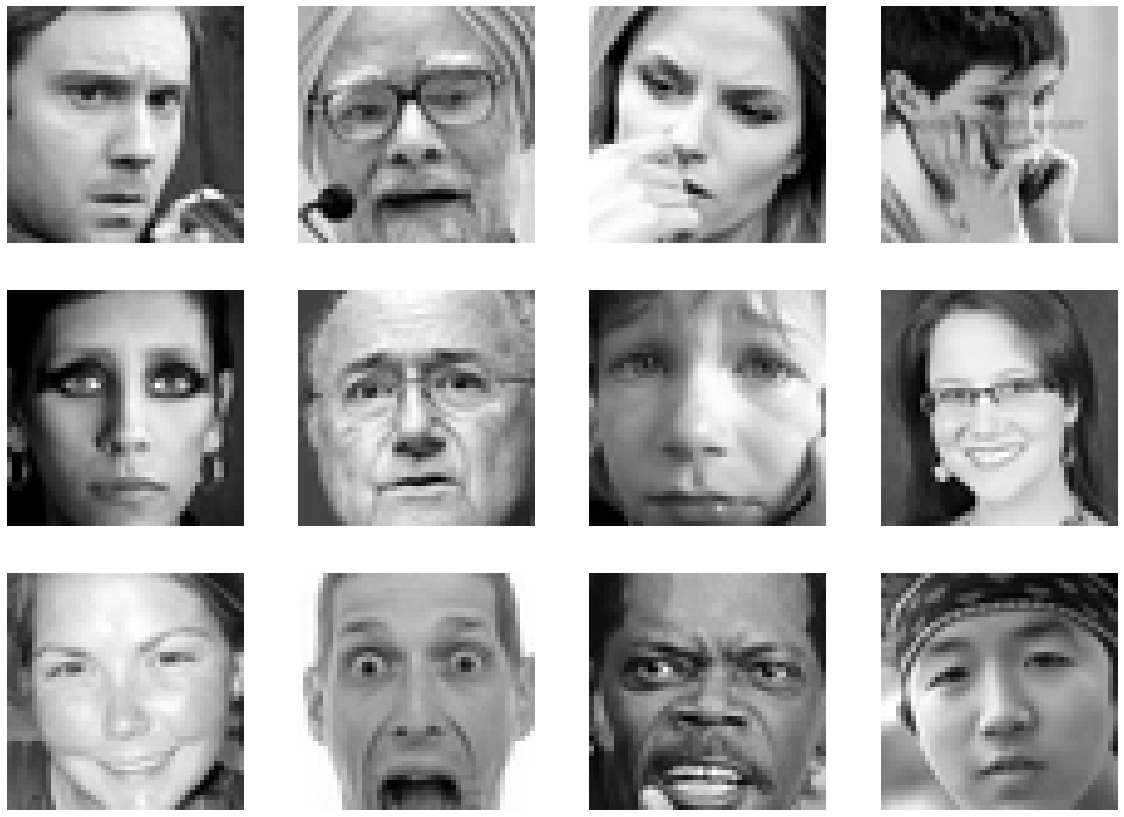

In [ ]:
def visualize_images(n_img = 4):
    indices = range(12)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  data['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images()

In [ ]:
X = data['pixels']
y = data['emotion']
X = np.array(list(map(str.split,X)),dtype = np.float32)
X /=255
X[0].shape

(2304,)

In [ ]:
X = X.reshape(-1,48,48,1)

In [ ]:
y = np.array(y)
y = y.reshape(y.shape[0],1)
y.shape

(31338, 1)

In [ ]:
x_train_fer2013,x_val_fer2013,y_train_fer2013,y_val_fer2013 = train_test_split(X,y,test_size = 0.2,random_state = 8)

In [ ]:
y_train_fer2013= to_categorical(y_train_fer2013,NUM_CLASSES)
y_val_fer2013 = to_categorical(y_val_fer2013,NUM_CLASSES)

### AffectNet Data for Models 2 and 3

http://mohammadmahoor.com/affectnet/

In [ ]:
train_dir = "G:\small_train"
image_size = (96, 96)

train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   rescale = 1./255,
                                   validation_split = 0.2
                                  )

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (image_size),
                                                    batch_size = 32,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

val_ds = validation_datagen.flow_from_directory( directory = train_dir,
                                                              target_size = (image_size),
                                                              batch_size = 32,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )


Found 31498 images belonging to 5 classes.
Found 7873 images belonging to 5 classes.


# Training our Neural Network Models
We have done some research on past architectures that have been used to build a model for emotion classification and modified them to see if we are able to obtain better results.

We will keep track of both the training and validation accuracy to 

(Experimentation with different architectures can be found in our other notebooks, these are just for best 4 models)

### Model 1: Using Kaggle dataset 

In [ ]:
input_shape = (48,48,1)
num_classes = 5
dropout = 0.5

model1 = Sequential()

#Layer 1
model1.add(Input(shape = input_shape))
model1.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model1.add(BatchNormalization())

#Layer 2
model1.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(dropout))

#Layer 3
model1.add(Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model1.add(BatchNormalization())

#Layer 4
model1.add(Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(dropout))

#Layer 5
model1.add(Conv2D(256,kernel_size = (3,3),activation = 'relu'))
model1.add(BatchNormalization())

#Layer 6
model1.add(Conv2D(256,kernel_size=(3,3),activation = 'relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(dropout))

model1.add(Flatten())

model1.add(Dense(256,activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Dropout(dropout))

model1.add(layers.Dense(num_classes,activation = 'softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                        

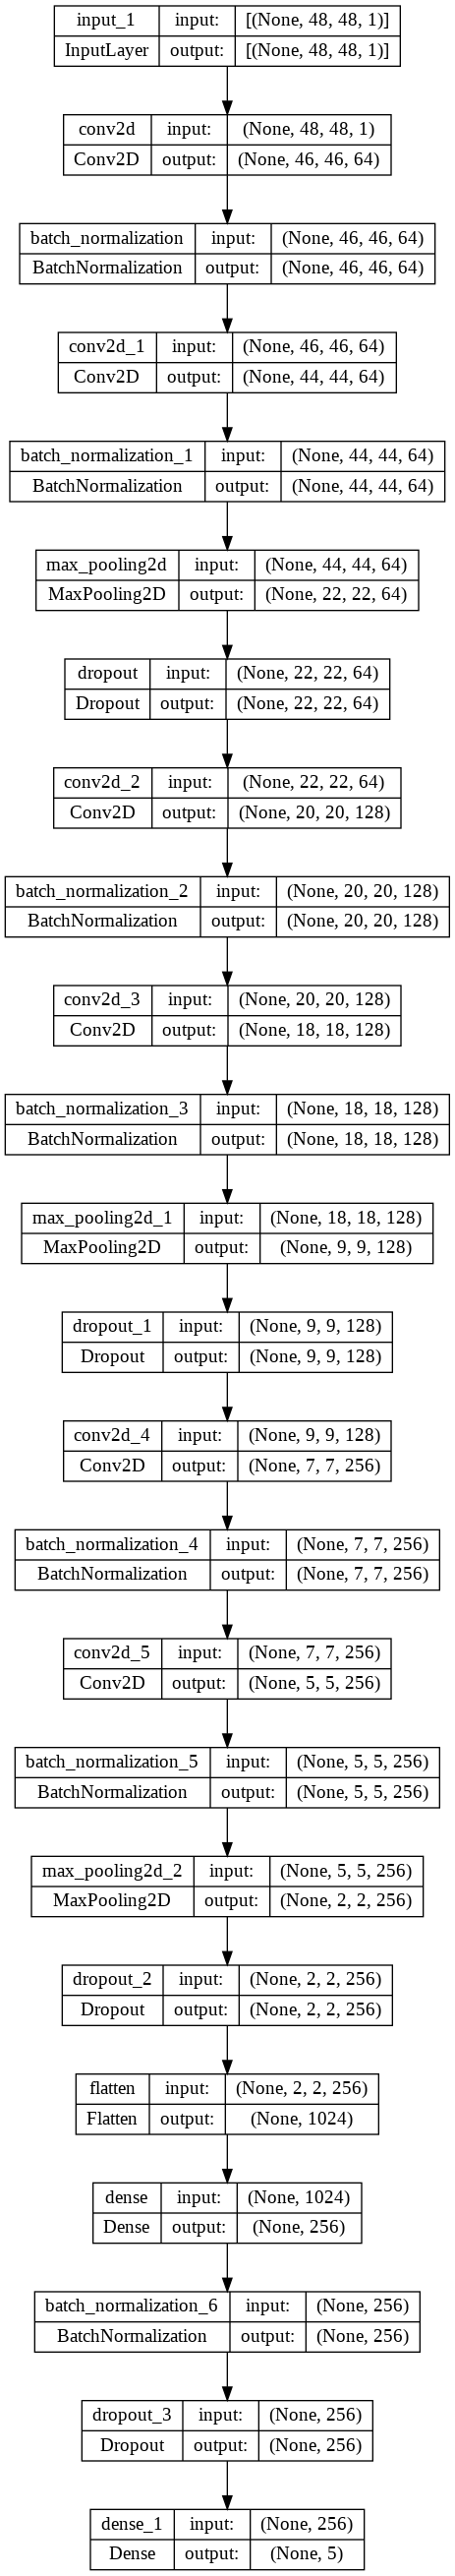

In [ ]:
plot_model(model1,to_file = 'model_1.png',show_shapes = True,show_layer_names = True)

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
model1.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])

epochs = 50

history1 = model1.fit(train_ds_kaggle,epochs = epochs,validation_data = val_ds_kaggle,verbose = 1)

Epoch 1/50
628/628 [==============================] - 37s 43ms/step - loss: 1.9384 - accuracy: 0.2629 - val_loss: 1.5368 - val_accuracy: 0.3319
Epoch 2/50
628/628 [==============================] - 25s 40ms/step - loss: 1.5039 - accuracy: 0.3529 - val_loss: 1.3752 - val_accuracy: 0.4233
Epoch 3/50
628/628 [==============================] - 26s 41ms/step - loss: 1.4062 - accuracy: 0.4053 - val_loss: 1.3180 - val_accuracy: 0.4524
Epoch 4/50
628/628 [==============================] - 25s 40ms/step - loss: 1.3241 - accuracy: 0.4454 - val_loss: 1.2144 - val_accuracy: 0.5018
Epoch 5/50
628/628 [==============================] - 25s 41ms/step - loss: 1.2726 - accuracy: 0.4752 - val_loss: 1.1816 - val_accuracy: 0.5259
Epoch 6/50
628/628 [==============================] - 25s 40ms/step - loss: 1.2261 - accuracy: 0.5006 - val_loss: 1.1189 - val_accuracy: 0.5532
Epoch 7/50
628/628 [==============================] - 26s 42ms/step - loss: 1.2011 - accuracy: 0.5100 - val_loss: 1.1082 - val_accuracy:

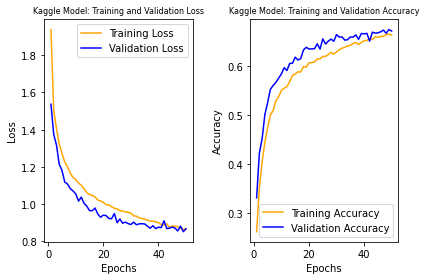

In [ ]:
loss_train = history1.history['loss']
loss_val = history1.history['val_loss']
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
epochs = range(1,51)
fig, axes = plt.subplots(1, 2)
# Plotting Model 1 Loss
axes[0].plot(epochs,loss_train,color = 'orange',label = 'Training Loss')
axes[0].plot(epochs,loss_val,'b',label = 'Validation Loss')
axes[0].set_title('Kaggle Model: Training and Validation Loss', fontsize=8)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
# Plotting Model 1 Accuracy
axes[1].plot(epochs,train_acc,color = 'orange',label = 'Training Accuracy')
axes[1].plot(epochs,val_acc,'b',label = 'Validation Accuracy')
axes[1].set_title('Kaggle Model: Training and Validation Accuracy', fontsize=8)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("Kaggle Model Statistics.png")

In [ ]:
model1.save('/content/gdrive/MyDrive/DS340_Project/FinalTrainedModels/KaggleEmotionClassification')

### Model 1: Using FER2013 data

In [ ]:
input_shape = (48,48,1)
num_classes = 5
dropout = 0.5

model2 = Sequential()

#Layer 1
model2.add(Input(shape = input_shape))
model2.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model2.add(BatchNormalization())

#Layer 2
model2.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(dropout))

#Layer 3
model2.add(Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model2.add(BatchNormalization())

#Layer 4
model2.add(Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(dropout))

#Layer 5
model2.add(Conv2D(256,kernel_size = (3,3),activation = 'relu'))
model2.add(BatchNormalization())

#Layer 6
model2.add(Conv2D(256,kernel_size=(3,3),activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size = (2,2)))
model2.add(Dropout(dropout))

model2.add(Flatten())

model2.add(Dense(256,activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(dropout))

model2.add(layers.Dense(num_classes,activation = 'softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_7 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_8 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                      

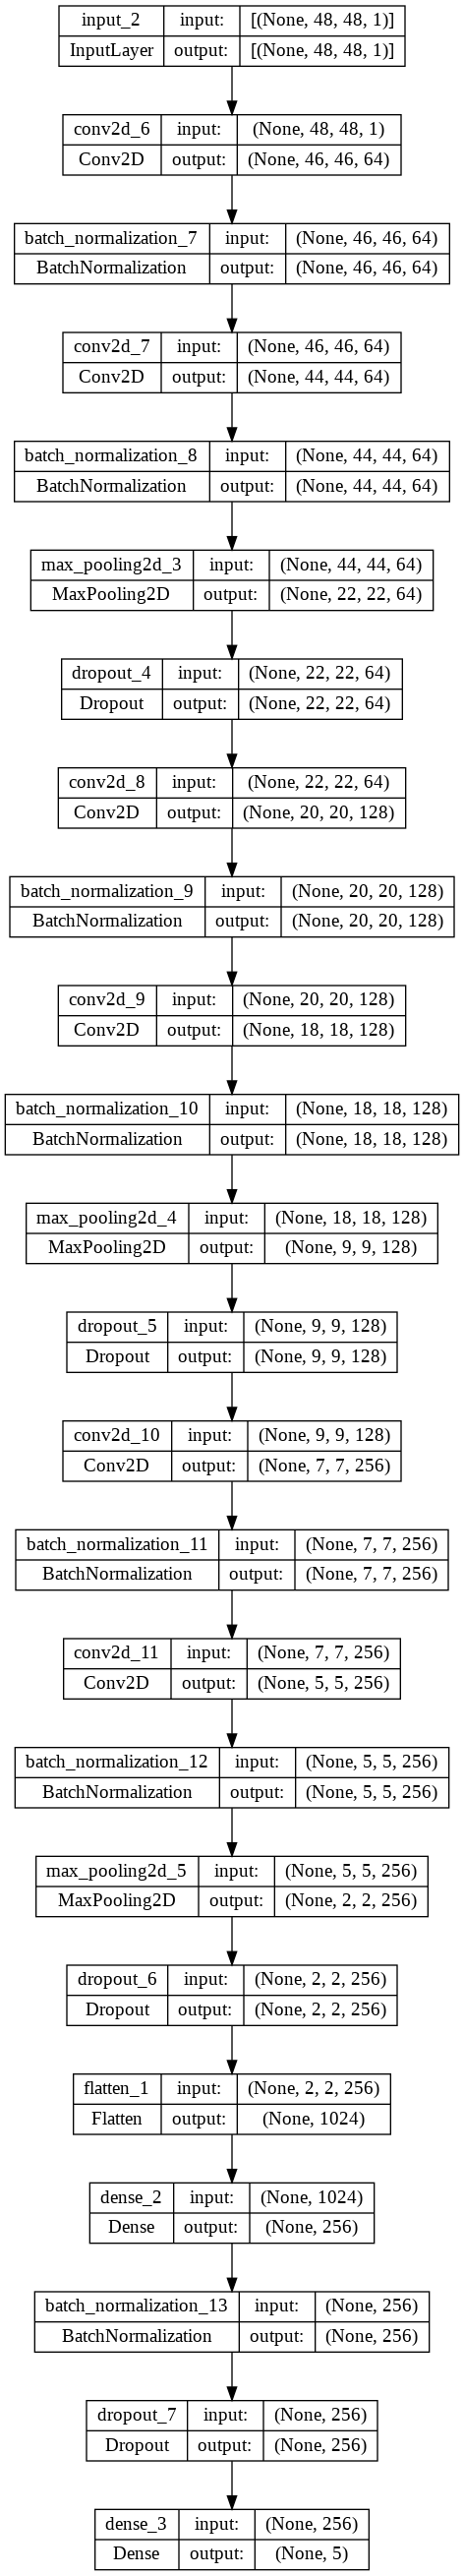

In [ ]:
plot_model(model2,to_file = 'model_2.png',show_shapes = True,show_layer_names = True)

In [ ]:
from keras import callbacks

early_stopping = callbacks.EarlyStopping(
     monitor='val_accuracy',
    min_delta=0.000005,
    patience = 15,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [early_stopping]

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
model2.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])
epochs = 50
history2 = model2.fit(x = x_train_fer2013,y = y_train_fer2013,epochs = epochs,validation_data = (x_val_fer2013,y_val_fer2013),verbose = 1,callbacks = callbacks)

Epoch 1/50
784/784 [==============================] - 15s 18ms/step - loss: 1.8661 - accuracy: 0.2596 - val_loss: 1.4870 - val_accuracy: 0.3519
Epoch 2/50
784/784 [==============================] - 13s 17ms/step - loss: 1.4272 - accuracy: 0.3995 - val_loss: 1.4173 - val_accuracy: 0.4108
Epoch 3/50
784/784 [==============================] - 13s 17ms/step - loss: 1.2554 - accuracy: 0.4812 - val_loss: 1.4810 - val_accuracy: 0.4265
Epoch 4/50
784/784 [==============================] - 13s 17ms/step - loss: 1.1873 - accuracy: 0.5170 - val_loss: 1.1702 - val_accuracy: 0.5341
Epoch 5/50
784/784 [==============================] - 13s 17ms/step - loss: 1.1463 - accuracy: 0.5350 - val_loss: 1.2995 - val_accuracy: 0.4850
Epoch 6/50
784/784 [==============================] - 13s 17ms/step - loss: 1.1078 - accuracy: 0.5514 - val_loss: 1.1976 - val_accuracy: 0.5233
Epoch 7/50
784/784 [==============================] - 13s 17ms/step - loss: 1.0734 - accuracy: 0.5702 - val_loss: 1.5152 - val_accuracy:

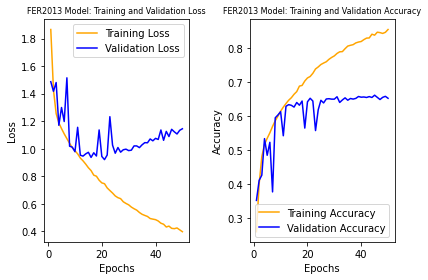

In [ ]:
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1,(len(loss_train)+1))
fig, axes = plt.subplots(1, 2)
# Plotting Model 2 Loss
axes[0].plot(epochs,loss_train,color = 'orange',label = 'Training Loss')
axes[0].plot(epochs,loss_val,'b',label = 'Validation Loss')
axes[0].set_title('FER2013 Model: Training and Validation Loss', fontsize=8)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
# Plotting Model 2 Accuracy
axes[1].plot(epochs,train_acc,color = 'orange',label = 'Training Accuracy')
axes[1].plot(epochs,val_acc,'b',label = 'Validation Accuracy')
axes[1].set_title('FER2013 Model: Training and Validation Accuracy', fontsize=8)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("FER2013 Model Statistics.png")

In [ ]:
model2.save('/content/gdrive/MyDrive/DS340_Project/FinalTrainedModels/FER2013EmotionClassification')

### Model 1: Using AffectNet data

In [ ]:
input_shape = (96,96,1)
num_classes = 5
dropout = 0.5

model5 = Sequential()

#Layer 1
model5.add(Input(shape = input_shape))
model5.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model5.add(BatchNormalization())

#Layer 2
model5.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size = (2,2)))
model5.add(Dropout(dropout))

#Layer 3
model5.add(Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model5.add(BatchNormalization())

#Layer 4
model5.add(Conv2D(128,kernel_size = (3,3),activation = 'relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size = (2,2)))
model5.add(Dropout(dropout))

#Layer 5
model5.add(Conv2D(256,kernel_size = (3,3),activation = 'relu'))
model5.add(BatchNormalization())

#Layer 6
model5.add(Conv2D(256,kernel_size=(3,3),activation = 'relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size = (2,2)))
model5.add(Dropout(dropout))

model5.add(Flatten())

model5.add(Dense(256,activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(dropout))

model5.add(layers.Dense(num_classes,activation = 'softmax'))

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 92, 92, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                        

In [ ]:
from keras import callbacks

early_stopping = callbacks.EarlyStopping(
     monitor='val_accuracy',
    min_delta=0.000005,
    patience = 15,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [early_stopping]

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
model5.compile(optimizer = opt,loss = 'categorical_crossentropy',metrics = ['accuracy'])
epochs = 50
history5 = model5.fit(train_ds,epochs = epochs,validation_data =val_ds,verbose = 1,callbacks = callbacks)

Epoch 1/50
985/985 [==============================] - 213s 207ms/step - loss: 1.6838 - accuracy: 0.3216 - val_loss: 1.3134 - val_accuracy: 0.4322
Epoch 2/50
985/985 [==============================] - 67s 68ms/step - loss: 1.2891 - accuracy: 0.4543 - val_loss: 1.4299 - val_accuracy: 0.3981
Epoch 3/50
985/985 [==============================] - 68s 69ms/step - loss: 1.1723 - accuracy: 0.5167 - val_loss: 1.0782 - val_accuracy: 0.5497
Epoch 4/50
985/985 [==============================] - 69s 70ms/step - loss: 1.1020 - accuracy: 0.5522 - val_loss: 0.9803 - val_accuracy: 0.6024
Epoch 5/50
985/985 [==============================] - 69s 70ms/step - loss: 1.0481 - accuracy: 0.5740 - val_loss: 0.9952 - val_accuracy: 0.6029
Epoch 6/50
985/985 [==============================] - 69s 70ms/step - loss: 0.9996 - accuracy: 0.5976 - val_loss: 0.9549 - val_accuracy: 0.6215
Epoch 7/50
985/985 [==============================] - 70s 71ms/step - loss: 0.9717 - accuracy: 0.6121 - val_loss: 0.8747 - val_accurac

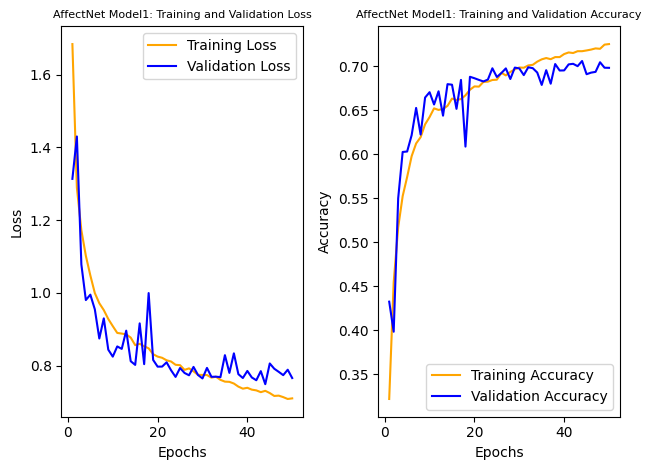

In [ ]:
loss_train = history5.history['loss']
loss_val = history5.history['val_loss']
train_acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
epochs = range(1,(len(loss_train)+1))
fig, axes = plt.subplots(1, 2)
# Plotting Model 2 Loss
axes[0].plot(epochs,loss_train,color = 'orange',label = 'Training Loss')
axes[0].plot(epochs,loss_val,'b',label = 'Validation Loss')
axes[0].set_title('AffectNet Model1: Training and Validation Loss', fontsize=8)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
# Plotting Model 2 Accuracy
axes[1].plot(epochs,train_acc,color = 'orange',label = 'Training Accuracy')
axes[1].plot(epochs,val_acc,'b',label = 'Validation Accuracy')
axes[1].set_title('AffectNet Model1: Training and Validation Accuracy', fontsize=8)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("FER2013 Model Statistics.png")

In [ ]:
model5.save("Model1AffectNet96x96")

INFO:tensorflow:Assets written to: Model1AffectNet96x96\assets


INFO:tensorflow:Assets written to: Model1AffectNet96x96\assets


### Model 2: The "Venturi Model"

Adapted model from this paper: https://ieeexplore.ieee.org/abstract/document/8787215

In [ ]:
model3 = keras.Sequential(
    [ 
      layers.Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(96, 96,1)),
      layers.Conv2D(256,(3,3), padding='same', activation='relu' ),
      layers.MaxPool2D(pool_size=(2, 2)),
      layers.Dropout(0.2),
     
      layers.Conv2D(128,(3,3), padding='same', activation='relu'),
      layers.Conv2D(128,(3,3), padding='same', activation='relu'),
      layers.MaxPool2D(pool_size=(2, 2)),
      layers.Dropout(0.2),
    
      layers.Conv2D(256,(3,3), padding='same', activation='relu'),
      layers.Conv2D(512,(3,3), padding='same', activation='relu'),
      layers.MaxPool2D(pool_size=(2, 2)),
      layers.Dropout(0.2),

      layers.Flatten(),
      layers.Dense(256,activation = 'relu'),
      layers.BatchNormalization(),
        
      layers.Dropout(0.5),

      layers.Dense(5, activation='softmax')
    ]
)
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 512)       5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 256)       1179904   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 128)       295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 128)       147584    
                                                        

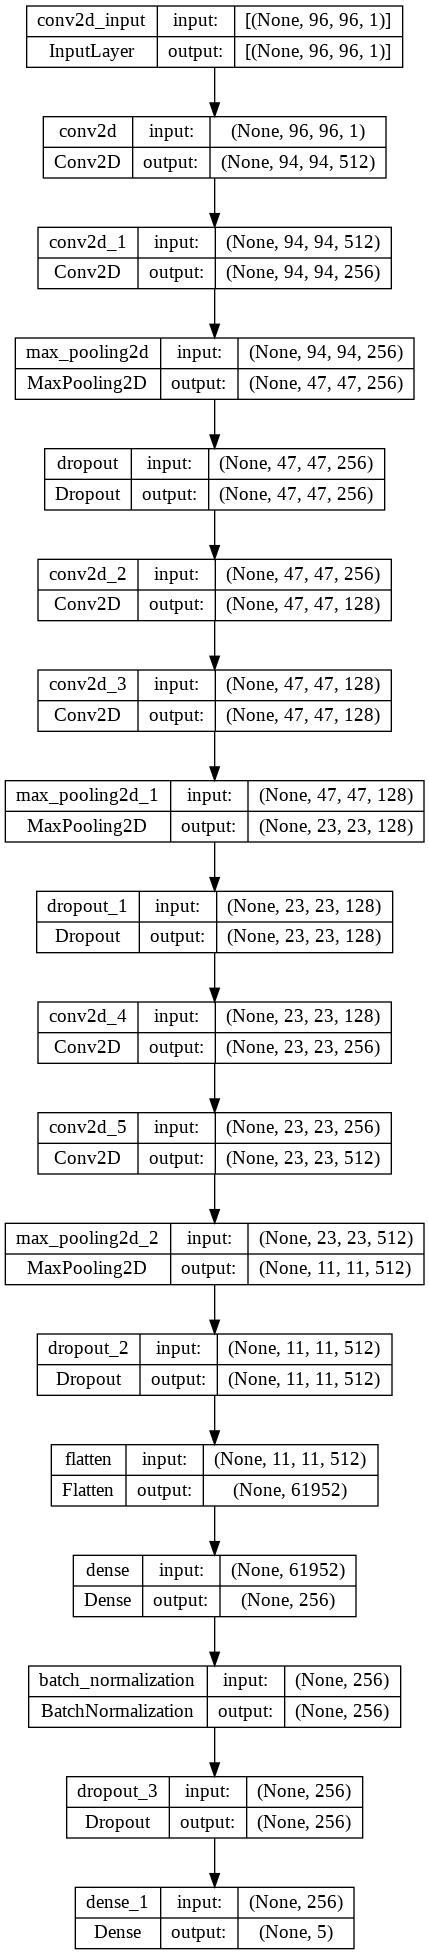

In [ ]:
plot_model(model3,to_file = 'venturi_model.png',show_shapes = True,show_layer_names = True)

In [ ]:
epochs = 50
opt = keras.optimizers.Adam(learning_rate=0.001)

model3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history3 = model3.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)

Epoch 1/50
985/985 [==============================] - 240s 240ms/step - loss: 1.6457 - accuracy: 0.2824 - val_loss: 1.5566 - val_accuracy: 0.3286
Epoch 2/50
985/985 [==============================] - 236s 240ms/step - loss: 1.5381 - accuracy: 0.3125 - val_loss: 1.5495 - val_accuracy: 0.2793
Epoch 3/50
985/985 [==============================] - 236s 240ms/step - loss: 1.4910 - accuracy: 0.3411 - val_loss: 1.3518 - val_accuracy: 0.4378
Epoch 4/50
985/985 [==============================] - 235s 238ms/step - loss: 1.3945 - accuracy: 0.4049 - val_loss: 1.3208 - val_accuracy: 0.4527
Epoch 5/50
985/985 [==============================] - 224s 227ms/step - loss: 1.2860 - accuracy: 0.4601 - val_loss: 1.1521 - val_accuracy: 0.5317
Epoch 6/50
985/985 [==============================] - 224s 227ms/step - loss: 1.2116 - accuracy: 0.4960 - val_loss: 1.1164 - val_accuracy: 0.5504
Epoch 7/50
985/985 [==============================] - 224s 227ms/step - loss: 1.1801 - accuracy: 0.5153 - val_loss: 1.0603 -

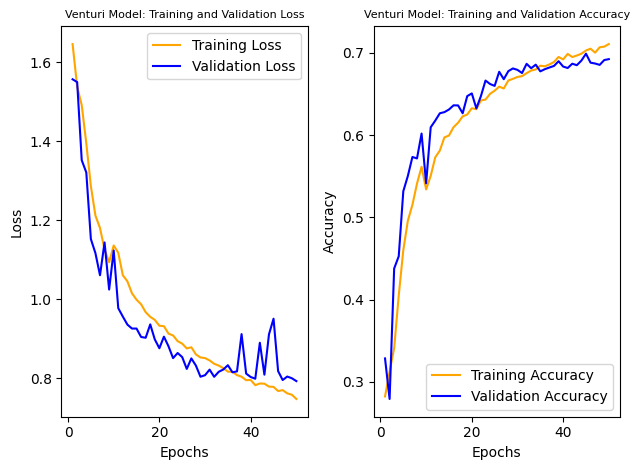

In [ ]:
loss_train = history3.history['loss']
loss_val = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
epochs = range(1,51)
fig, axes = plt.subplots(1, 2)
# Plotting Model 1 Loss
axes[0].plot(epochs,loss_train,color = 'orange',label = 'Training Loss')
axes[0].plot(epochs,loss_val,'b',label = 'Validation Loss')
axes[0].set_title('Venturi Model: Training and Validation Loss', fontsize=8)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
# Plotting Model 1 Accuracy
axes[1].plot(epochs,train_acc,color = 'orange',label = 'Training Accuracy')
axes[1].plot(epochs,val_acc,'b',label = 'Validation Accuracy')
axes[1].set_title('Venturi Model: Training and Validation Accuracy', fontsize=8)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("Venturi Model Statistics.png")

In [ ]:
model3.save("VenturiEmotionClassification96x96")

INFO:tensorflow:Assets written to: VenturiEmotionClassification96x96\assets


INFO:tensorflow:Assets written to: VenturiEmotionClassification96x96\assets


### Model 3: 32-64-128-256-512

Adapted model from https://www.youtube.com/watch?v=P4OevrwTq78

Resize data for next mode (224x224)

In [ ]:
train_dir = "G:\small_train"
image_size = (224, 224)

train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   samplewise_std_normalization = True
                                  )

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (image_size),
                                                    batch_size = 32,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2, samplewise_std_normalization = True)

val_ds = validation_datagen.flow_from_directory( directory = train_dir,
                                                              target_size = (image_size),
                                                              batch_size = 32,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )


C:\Users\Danny Skahill\miniconda3\envs\GPUenv\lib\site-packages\keras\preprocessing\image.py:1471: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


Found 31498 images belonging to 5 classes.
Found 7873 images belonging to 5 classes.


In [ ]:
model4 = keras.Sequential(
    [ 
      layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,1)),
      layers.MaxPool2D(pool_size=(2, 2)),
      layers.Dropout(0.2),
     
      layers.Conv2D(64,(3,3), padding='same', activation='relu'),
      layers.MaxPool2D(pool_size=(2, 2)),
      layers.Dropout(0.2),
    
      layers.Conv2D(128,(3,3), padding='same', activation='relu'),
      layers.MaxPool2D(pool_size=(2, 2)),
      layers.Dropout(0.2),
        
      layers.Conv2D(256,(5,5), padding='same', activation='relu'),
      layers.MaxPool2D(pool_size=(3, 3)),
      layers.Dropout(0.2),
        
      layers.Conv2D(512,(5,5), padding='same', activation='relu'),
      layers.MaxPool2D(pool_size=(3, 3)),
      layers.Dropout(0.2),

      layers.Flatten(),
      layers.Dense(1000,activation = 'relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),

      layers.Dense(5, activation='softmax')
    ]
)
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 55, 55, 64)       

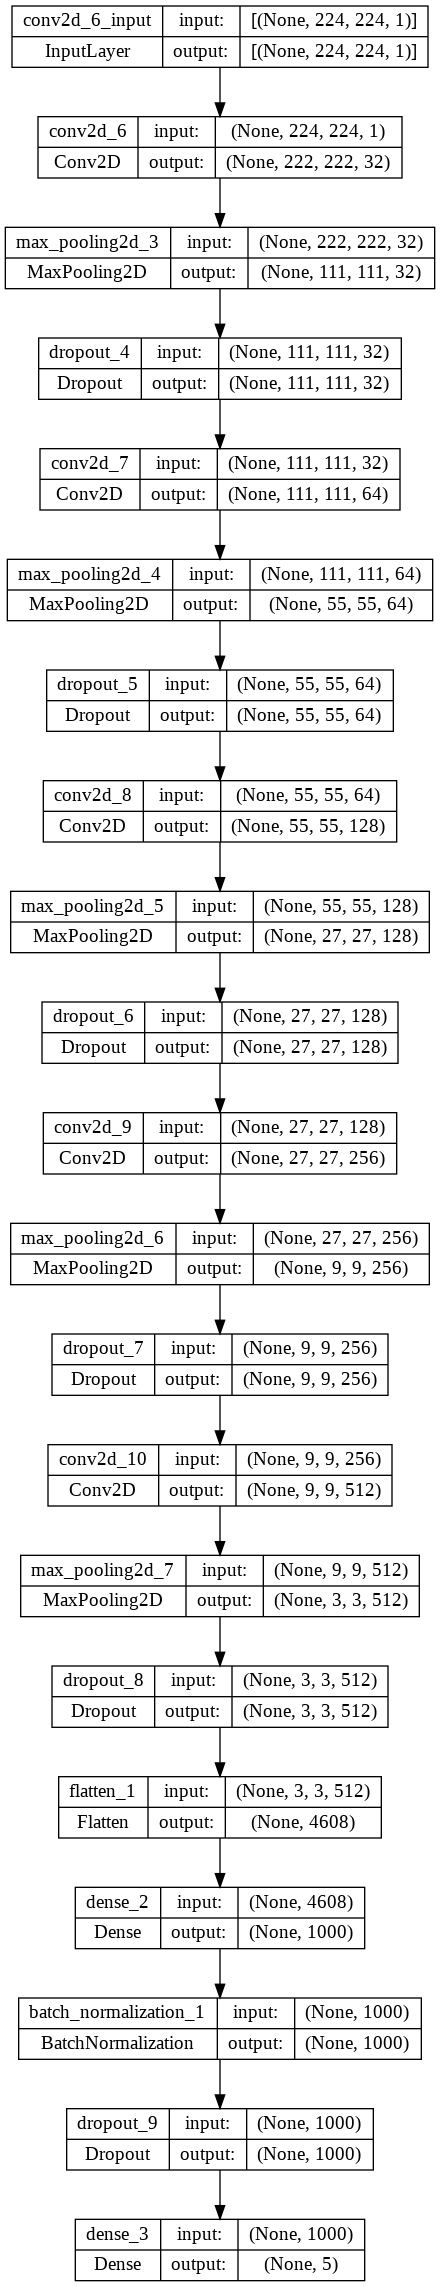

In [ ]:
plot_model(model4,to_file = 'model_3.png',show_shapes = True,show_layer_names = True)

In [ ]:
epochs = 50
opt = keras.optimizers.RMSprop(learning_rate=0.001)

model4.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history4 = model4.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)

Epoch 1/50
985/985 [==============================] - 129s 129ms/step - loss: 1.4674 - accuracy: 0.4167 - val_loss: 1.3340 - val_accuracy: 0.4729
Epoch 2/50
985/985 [==============================] - 125s 127ms/step - loss: 1.0830 - accuracy: 0.5639 - val_loss: 1.2320 - val_accuracy: 0.5422
Epoch 3/50
985/985 [==============================] - 124s 126ms/step - loss: 0.9951 - accuracy: 0.6063 - val_loss: 0.9136 - val_accuracy: 0.6343
Epoch 4/50
985/985 [==============================] - 124s 125ms/step - loss: 0.9379 - accuracy: 0.6292 - val_loss: 0.9225 - val_accuracy: 0.6403
Epoch 5/50
985/985 [==============================] - 124s 126ms/step - loss: 0.9132 - accuracy: 0.6420 - val_loss: 1.0917 - val_accuracy: 0.5869
Epoch 6/50
985/985 [==============================] - 125s 127ms/step - loss: 0.8825 - accuracy: 0.6534 - val_loss: 0.9318 - val_accuracy: 0.6366
Epoch 7/50
985/985 [==============================] - 127s 129ms/step - loss: 0.8674 - accuracy: 0.6607 - val_loss: 0.9212 -

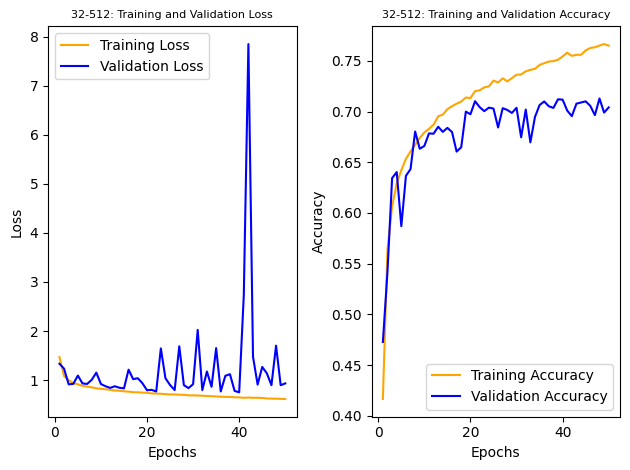

In [ ]:
loss_train = history4.history['loss']
loss_val = history4.history['val_loss']
train_acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
epochs = range(1,51)
fig, axes = plt.subplots(1, 2)
# Plotting Model 1 Loss
axes[0].plot(epochs,loss_train,color = 'orange',label = 'Training Loss')
axes[0].plot(epochs,loss_val,'b',label = 'Validation Loss')
axes[0].set_title('32-512: Training and Validation Loss', fontsize=8)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
# Plotting Model 1 Accuracy
axes[1].plot(epochs,train_acc,color = 'orange',label = 'Training Accuracy')
axes[1].plot(epochs,val_acc,'b',label = 'Validation Accuracy')
axes[1].set_title('32-512: Training and Validation Accuracy', fontsize=8)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("32-512 Model Statistics.png")

In [ ]:
model4.save("32-512classificationRMSProp224x224")

INFO:tensorflow:Assets written to: 32-512classificationRMSProp224x224\assets


INFO:tensorflow:Assets written to: 32-512classificationRMSProp224x224\assets


# Ensemble experimentation

Since we had 4 models that achieve relatively similar accuracies, we wanted to see if combining them into an ensemble would improve prediction accuracy. In the end we decided against using the ensemble method, but here is the code we produced

In [ ]:
model_filepaths =  [
                    '/content/gdrive/MyDrive/DS340_Project/Trained_Models/NNEmotionClassification-FER2013_Oversampling',
                    '/content/gdrive/MyDrive/DS340_Project/Trained_Models/NNEmotionClassification-Kaggle_data_1',
                    '/content/gdrive/MyDrive/DS340_Project/Trained_Models/NNEmotionClassification-Kaggle_data_2',
                    '/content/gdrive/MyDrive/DS340_Project/Trained_Models/NNEmotionClassification-FER2013',
                    ]
#'/content/gdrive/MyDrive/DS340_Project/Trained_Models/NNEmotionClassification2-Venturi',

loaded_models = []
for f in model_filepaths:
  loaded_models.append(tf.keras.models.load_model(f))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [ ]:
NUM_EMOTIONS = 5
def ensemble_predict(file,models,selection_type):
  n_models = len(models)
  model_predictions = [0]* len(models)
  """
  return max probability out of model predictions
  """
  img = cv2.imread(file)
  #cv2_imshow(img)

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  detector= cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
  faces = detector.detectMultiScale(gray, 1.1, 4)
  for (x,y,w,h) in faces:
    cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    faces = gray[y:y+h,x:x+w]
  #cv2_imshow(faces)
  
  cv2.imwrite("webcam_face.jpg",faces)

  filepath = 'webcam_face.jpg'
  img = cv2.imread(filepath)
  cv2_imshow(img)
  
  
  for i,m in enumerate(models):
    config  = m.get_config()
    input_shape = config['layers'][0]['config']['batch_input_shape']
    n,input_x,input_y,input_z = input_shape

    #print(input_x,input_y,input_z)

    resized_img = cv2.resize(img,(input_x,input_y))
    #print(f"resized dim: {resized_img.shape}")
    cv2.imwrite('resized_webcam_face.jpg',resized_img)
    #cv2_imshow(resized_img)

    input_filepath = 'resized_webcam_face.jpg'
    img = cv2.imread(input_filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #cv2_imshow(img)

    input = np.array(list(img),dtype = np.float32)
    input /= 255
    input = input[np.newaxis,:,:,np.newaxis]
    #print(input.shape)
    if selection_type == 'max':
      model_predictions[i] = m.predict(input)[0]
    else:
      model_predictions[i] += m.predict(input)[0] / len(models)
  #print(model_predictions)
  return  emotion_prediction(model_predictions[0])

def emotion_prediction(emotion_probs):
  emotions = ['Angry','Fear','Happy','Neutral','Sad']
  #print(emotion_probs)
  max_p = 0
  predict_emotion = ''
  for i,p in enumerate(emotion_probs):
    if p > max_p:
      max_p = p
      predict_emotion = emotions[i]
  return predict_emotion


def emotion_detection_ensemble():
  try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
  
    # Show the image which was just taken.
    display(Image(filename))

  except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
    print(str(err))
  
  filepath = 'photo.jpg'

  result = ensemble_predict(filepath,loaded_models,'avg')
  return result
  
emotion_detection_ensemble()

# Video Analysis with Neural Network

Now that we have our trained neural networks, we wanted to use them to show emotion change throughout videos. 

Resources used to help utilize CV2 library: 

https://theailearner.com/2018/10/15/extracting-and-saving-video-frames-using-opencv-python/

https://realpython.com/face-detection-in-python-using-a-webcam/


In [ ]:
def video_emotion_stats(model, video, classes):
    """
    Args: 
        model- trained neural network
        video- video we want to output emotion stats to 
        classes- a dictionary of the different classes
    Returns:
    
    """
    #load the sequence of images 
    img_seq = vid_to_img(video)
    
    #array for predicted labels
    pred_labels = []
    changes = []
    
    #predict emotion at each image 
    for img in img_seq:
        img = Image.fromarray(img)
        img = img.convert('L')
        img = img.resize((224,224))
        img = np.array(img)
        img = img.reshape((-1, 224, 224))
        label = model.predict(np.array(img), verbose=0)
        pred_labels.append(np.argmax(label))
        
    #find how many changes there are     
    for l in range(len(pred_labels)):
        if l == 0:
            changes.append(pred_labels[l])
        elif pred_labels[l] != pred_labels[l-1]:
            changes.append(pred_labels[l])
    
    #generate a report on the emotions in the video
    emotion_report(pred_labels, changes, classes)
    
    return(changes, pred_labels)
    
    
def vid_to_img(video):
    """
    Args: 
        video- video we want to convert to image frames
    Returns
        img_seq- an array of cropped faces images from the video 
    """
    cap = video
    i = 0
    img_seq = []
    while(cap.isOpened()):
        ret, img = cap.read()
        if ret == False:
            break
        #select every 10th frame
        if i % 8 == 0:
            #convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #opencv cascade
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            #detecting faces
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
            #crop the image to the face
            for (x, y, w, h) in faces:
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
                faces = img[y:y + h, x:x + w]
            img_seq.append(faces)
        i+=1
    cap.release()
    return img_seq

def emotion_report(pred_labels, changes, classes):
    """
    Function to generate the report of emotions from a video
    
    Args:
        pred_labels- the predicted labels generated from the model
        changes- the labels that change over the course of the video
        classes- a dictionary of the classes used for prediction
    Returns:
        a report of various emotion statistics
    """
    
    print(f"Emotions changed {len(changes)} time(s)")
    print()
    
    #30 fps, and we took every 8th frame so duration = len*5/30 in seconds
    vid_len = (len(pred_labels)*8)/30
    for key in classes:
        #make the assumption the emotion lasted for the 5 frames after too
        emo_time = round((pred_labels.count(classes[key])*8)/30, 2)
        pct_emo = round((emo_time/vid_len)*100, 2)
        print(f"Time spent {key}: {emo_time}s for video length {round(vid_len, 2)}s.\nPercentage {key}: {pct_emo}%")
        print("-----------------------------------------------------------")
        
    #ganntt chart showing when each emotion happened    
    d = []
    time = 0
    last = 0
    for t in range(len(pred_labels)):
        if t == 0:
            time = 8
            continue

        if pred_labels[t] != pred_labels[t-1]:
            d.append(dict(Start=last/30, Finish=time/30, Emotion=get_key(pred_labels[t-1], classes)))
            last = copy.deepcopy(time)
            time += 8
        elif t == (len(pred_labels)-1):
            time += 8
            d.append(dict(Start=last/30, Finish=time/30, Emotion=get_key(pred_labels[t], classes)))
            last = copy.deepcopy(time)
        else:
            time += 8

    df = pd.DataFrame(d)

    df["Start"] = pd.to_datetime(df["Start"], unit='s')
    df["Finish"] = pd.to_datetime(df["Finish"], unit='s')

    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Emotion", color="Emotion")
    fig.update_xaxes(
        tickformat="%M:%S.%L", tickformatstops=[dict(dtickrange=[0, 60*1000*(time/30)], value="%M:%S.%L")])
    fig.show(renderer="colab")
    
    #plot graphs
    #fig, axes = plt.subplots(1,2)
    #sns.histplot(pred_labels, ax=axes[0])
    #sns.lineplot(range(len(pred_labels)), pred_labels, ax=axes[1]) 
    #plt.show()

def get_key(val, dictionary):
    for key, value in dictionary.items():
        if val == value:
            return key
 
    return "key doesn't exist"

In [ ]:
#load model
model_path = "/content/gdrive/MyDrive/NNEmotionClassification2-Venturi"
trained_model = keras.models.load_model(model_path)

#load categories as defined by Keras 
classes = {'Anger': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4}

#load video
video_path = '/content/gdrive/MyDrive/dannytest.mov'
video = cv2.VideoCapture(video_path)

video_emotion_stats(trained_model, video, classes)

video.release()

Emotions changed 9 time(s)

Time spent Anger: 0.53s for video length 8.8s.
Percentage Anger: 6.02%
-----------------------------------------------------------
Time spent Fear: 0.53s for video length 8.8s.
Percentage Fear: 6.02%
-----------------------------------------------------------
Time spent Happy: 7.47s for video length 8.8s.
Percentage Happy: 84.89%
-----------------------------------------------------------
Time spent Neutral: 0.27s for video length 8.8s.
Percentage Neutral: 3.07%
-----------------------------------------------------------
Time spent Sad: 0.0s for video length 8.8s.
Percentage Sad: 0.0%
-----------------------------------------------------------


# Extending Neural Network to Live Video Feed

Helper functions that will apply to the following sections.

Resources for live capture implementation:

https://towardsdatascience.com/implementing-real-time-object-detection-system-using-pytorch-and-opencv-70bac41148f7

In [12]:

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [11]:
def js_to_image(js_reply):
  """
  Params: 
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  #decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  
  #convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes,dtype = np.uint8)

  #decode numpy array into OpenCV image
  img = cv2.imdecode(jpg_as_np,flags = 1)

  return img

#function to convert OpenCV bounding box into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params: 
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream

  Returns:
          bytes: base64 image byte string
  """

  #convert array into PIL Image
  bbox_PIL = PIL.Image.fromarray(bbox_array,'RGBA')
  iobuf = io.BytesIO()

  #format bbox into png for return
  bbox_PIL.save(iobuf,format = 'png')

  #format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()),'utf-8')))

  return bbox_bytes



Haar Cascade Classifier

We will use a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam.

OpenCV has a pre-trained Haar Cascade face detection model.

In [5]:
#initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Live Video Capture with Neural Network Prediction

In [7]:
model = tf.keras.models.load_model("/content/gdrive/MyDrive/DS340_Project/Trained Models/NNEmotionClassification-FER2013")

In [25]:
def photo_predict(model):
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  config  = model.get_config()
  input_shape = config['layers'][0]['config']['batch_input_shape']
  n,input_x,input_y,input_z = input_shape
  
  # Show the image which was just taken.
  

  image = cv2.imread(filename)
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  for (x,y,w,h) in faces:
    cv2.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
    faces = gray[y:y+h,x:x+w]
    cv2.imwrite("detected_face.jpg",faces)

  filepath = 'detected_face.jpg'
  img = cv2.imread(filepath)
  original_img = cv2.imread(filepath)
  resized_img = cv2.resize(original_img,(input_x,input_y))
  
  cv2.imwrite('resized_webcam_face.jpg',resized_img)
  input_filepath = 'resized_webcam_face.jpg'
  img = cv2.imread(input_filepath)

  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  input = np.array(list(img),dtype = np.float32)
  input /= 255
  input = input[np.newaxis,:,:,np.newaxis]
  cv2_imshow(img)
  return emotion_prediction(model.predict(input)[0])

def emotion_prediction(emotion_probs):
  emotions = ['Angry','Fear','Happy','Neutral','Sad']
  #print(emotion_probs)
  max_p = 0
  predict_emotion = ''
  for i,p in enumerate(emotion_probs):
    if p > max_p:
      max_p = p
      predict_emotion = emotions[i]
  return predict_emotion

### Test Run of Emotion Predictions from webcam capture

<IPython.core.display.Javascript object>

Saved to photo.jpg


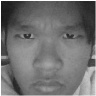

1/1 [==============================] - 0s 16ms/step
Angry


<IPython.core.display.Javascript object>

Saved to photo.jpg


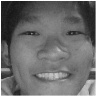

1/1 [==============================] - 0s 15ms/step
Happy


<IPython.core.display.Javascript object>

Saved to photo.jpg


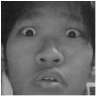

1/1 [==============================] - 0s 18ms/step
Fear


In [51]:
for i in range(3):
  print(photo_predict(model))

## Live Video with Neural Netowrk Live Predictions

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label,bbox):
  data = eval_js('stream_frame("{}","{}")'.format(label,bbox))
  return data

def pred_emo(model, frame, classes):
    """
    Args: 
        model- trained neural network
        video- video we want to output emotion stats to 
        classes- a dictionary of the different classes
    Returns:
    
    """
    config  = model.get_config()
    input_shape = config['layers'][0]['config']['batch_input_shape']
    n,input_x,input_y,input_z = input_shape
    #array for predicted labels
    pred_labels = []
    changes = []

    #predict emotion at each image 
    img_seq = frame
    for img in img_seq:
        img = PIL.Image.fromarray(img)
        img = img.convert('L')
        img = img.resize((input_x,input_y))
        img = np.array(img)
        img = img.reshape((-1, input_x, input_y))
        label = model.predict(np.array(img), verbose=0)
        return classes[np.argmax(label)]

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/VenturiEmotionClassification96x96")
classes = {0:'Anger', 1:'Fear', 2:'Happy', 3:'Neutral', 4:'Sad'}

Running the following cell will show live video with our neural network predictions.

*no output is currently shown because once the live capture stops it deletes all output*

In [ ]:
emos = []
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0
while True:
  js_reply = video_frame(label_html,bbox)
  if not js_reply:
    break
  
  img = js_to_image(js_reply["img"])

  bbox_array = np.zeros([480,640,4],dtype = np.uint8)

  gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

  faces = face_cascade.detectMultiScale(gray)

  x = 0
  y = 0
  for (x,y,w,h) in faces:
    bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
    faces = img[y:y + h, x:x + w]
  res = pred_emo(model, faces, classes)
  print("\r", res, end="")
  cv2.putText(bbox_array, res, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

  
  bbox_array[:,:,3] =( bbox_array.max(axis = 2)>0).astype(int)*255

  bbox_bytes = bbox_to_bytes(bbox_array)

  bbox = bbox_bytes


<IPython.core.display.Javascript object>

 Anger